### Technical Details -- for reference

1. How to swap two pandas dataframe?
https://stackoverflow.com/questions/25649429/how-to-swap-two-dataframe-columns

2. Calling Function From another Function within Same class 
https://www.geeksforgeeks.org/python-call-function-from-another-function/

3.  
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

4. label an axis on seaborn plot
https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot



In July 2021, a group of students took a simulated GEPT elementary level test, and we collected their complete answers and test score via google form and store them into two csv files: `1istening` and `reading`. 

The goal of the data analysis is as follows:

1. Know the indivduals' total test scores. 
2. Show the people who passed the test and who didn't
3. Rank the student who passed or didn't pass the test.

### Step 1 Inspect the Dataset
Import the dataset, do some cleaning and then show the head of each dataframe. I have mapped the name of the student to an ancient people in the "姓名" column beforehand to protect student's privacy.

In [65]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
listening = pd.read_csv("https://raw.githubusercontent.com/Frankkao813/DataAnalysis/main/Dataset/%E5%88%9D%E7%B4%9A%E8%81%BD%E5%8A%9B_new.csv")
reading = pd.read_csv("https://raw.githubusercontent.com/Frankkao813/DataAnalysis/main/Dataset/%E5%88%9D%E7%B4%9A%E9%96%B1%E8%AE%80_new.csv")
print(len(listening), len(reading))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
35 36


In [66]:
#drop by index then reindex()
listening["姓名"] = listening["姓名"].str.strip()
listening = listening.rename(columns = {"分數": "聽力成績"})
listening = listening.drop(columns=["Unnamed: 0"])
listening.head()

,姓名,聽力成績,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,司馬相如,60 / 120,C,D,C,C,B,C,B,D,A,A,A,A,B,A,D,B,A,C,B,B,B,B,B,D,B,C,A,C,B,A
1,張角,92 / 120,C,B,C,B,B,A,C,C,A,B,A,A,B,A,B,A,B,B,A,B,B,B,C,C,B,C,C,C,B,B
2,商湯,96 / 120,B,B,C,B,B,A,B,B,A,B,C,A,B,A,B,B,B,B,C,A,B,A,A,B,B,C,C,B,B,B
3,管仲,48 / 120,B,B,C,A,A,A,B,C,A,B,B,B,C,B,B,A,C,B,B,B,B,C,A,A,C,B,A,C,A,A
4,廉頗,52 / 120,C,C,B,A,C,A,B,A,C,A,C,A,B,B,A,C,B,A,C,B,A,C,B,B,A,A,C,C,A,B


In [67]:
reading["中文姓名"] = reading["姓名"].str.strip()
reading = reading.rename(columns = {"分數": "閱讀成績"})
reading = reading.drop(columns=["Unnamed: 0", "中文姓名"])
reading.head()

,姓名,閱讀成績,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,商湯,77 / 120,C,D,C,A,B,B,A,B,B,D,D,B,D,C,C,C,A,D,B,B,C,A,A,A,D,A,A,A,B,D,D,C,B,C,D
1,武丁,71 / 120,B,D,D,A,C,C,D,B,B,B,D,B,C,C,C,B,A,C,B,B,C,C,C,A,A,A,B,A,B,D,C,A,D,D,C
2,周文王,50 / 120,A,A,D,C,A,C,B,C,A,C,B,B,A,D,C,C,D,B,A,C,A,C,D,B,C,A,A,A,B,D,C,C,B,C,D
3,召公,100 / 120,B,D,D,A,A,B,D,B,B,D,D,B,D,A,C,A,A,D,D,B,C,A,A,B,B,A,A,A,B,B,C,C,B,C,D
4,魯班,69 / 120,B,D,C,A,B,B,C,B,B,B,A,B,D,A,C,A,A,C,B,B,B,A,D,C,D,A,A,D,B,B,B,A,D,C,D


### Step 2: write the class method needed for the analysis

Write the class and class method for this analysis. The brief introduction of method is as follows:
* `pair_name`: The listening and reading scores were collected separately, meaning that students' name sequence may not be the same. Therefore, we have to find the same names in each dataframe and pair the scores. The result is stored into `df.pair`
* `clean_table`: The objective is to strip "/ 120" string and tranform the column (聽力成績 or 閱讀成績) into integer value
* `show_Pass_notPass`: By using this method, we can pass in a logic and check whether the student passed the test.
* `group_true_false`: After showing whether the student passed the test, we should classify the student into two groups, which are the students passed and the student failed.
* `draw graph`: We plot the listening and reading test scores to see student's overall performance

In [57]:
import seaborn as sns
from scipy.stats import pearsonr
class Gept_Result:
    def __init__(self, df1, df2):
        self.df1 = df1
        self.df2 = df2

    def pair_name(self):
            
        '''
        * You have to rename the column first ("聽力成績" or "閱讀成績")
        * df1 has the max row by default. 
        '''

        try: 
            df1_new = self.df1.loc[:, ["姓名", "聽力成績"]]
            df2_new = self.df2.loc[:, ["姓名", "閱讀成績"]]
        except KeyError:
            df1_new = self.df1.loc[:, ["姓名", "閱讀成績"]]
            df2_new = self.df2.loc[:, ["姓名", "聽力成績"]]

        # number of the item fit
        fit_count = 0

        # how many loops 
        loop_count = 0

        if len(df1_new) < len(df2_new):
            temp = df2_new
            df2_new = df1_new
            df1_new = temp

        df1_name = df1_new["姓名"].tolist()
        df2_name = df2_new["姓名"].tolist()

        score_append = []
        df1_name_remove = df1_name.copy()
        df2_name_remove = df2_name.copy()

        for i in df1_name_remove[:]:
            loop_count +=1

            if i in df2_name_remove:
                score_append.append(df2_new.iloc[df2_name.index(i),1])
                fit_count += 1
                df1_name_remove.remove(i)
                df2_name_remove.remove(i)

            if loop_count != fit_count:
                score_append.append("0 / 120")
                fit_count += 1

        extract_df2_name = df2_new.columns[1]
        df1_new[extract_df2_name] = score_append

        if df1_new.columns[2] != "閱讀成績":
            #swap two rows by "reindex" method
            columns_titles = ["姓名", "聽力成績", "閱讀成績"]
            df1_new = df1_new.reindex(columns = columns_titles)
        df_pair = df1_new
        return df1_new

    def clean_table(self):
        # strip the "/ 120" string and turn the value type into integer
        raw_table = self.pair_name()
        raw_table["聽力成績"] = [int(element) for element in raw_table["聽力成績"].str.replace("/ 120", "")]
        raw_table["閱讀成績"] = [int(element) for element in raw_table["閱讀成績"].str.replace("/ 120", "")]
        raw_table["總成績"] = raw_table.iloc[:,1:3].sum(axis = 1)
        self.score_clean_table = raw_table
        return self.score_clean_table

    def show_pass_notPass(self):
        table = self.clean_table()
        logic = (table["聽力成績"] >= 72) & (table["閱讀成績"] >= 72) & (table["總成績"] >= 160)
        table["通過"] = logic 
        self.new_table = table
        return self.new_table
    
    def group_true_false(self, boolean):
        pass_table = self.show_pass_notPass()
        sorted_score = pass_table.sort_values("總成績", ascending = False)
        grouped_people = sorted_score.groupby("通過")
        pass_people = grouped_people.get_group(boolean)
        return pass_people
    
    def draw_graph(self, name):
        ''' 
        use matplotlib.hist to show quantiative data
        '''
        convertDict = {"聽力成績": "Listening Score", "閱讀成績": "Reading Score"}
        table = self.clean_table()
        score = table[f"{name}"].tolist()
        bin_size = 20
        bin_edges = np.arange(0 - bin_size/2, 120 + bin_size/2 + bin_size, bin_size)
        plt.hist(score, bins = bin_edges, rwidth = 0.95)
        plt.xticks(np.arange(0, 120+bin_size, bin_size))
        plt.xlabel("Score")
        plt.ylabel("number of people")
        plt.title(f"{convertDict.get(name,0)} Bar Plot")
        plt.show()
    def correlation(self):
        '''
        check whether there are correlation between listening scores and reading score
        '''
        table = self.clean_table()
        ax = sns.scatterplot(data = table, x = "聽力成績", y = "閱讀成績")
        # Seaborn's barplot returns an axis-object (https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot)
        ax.set(xlabel = "Listening Score", ylabel = "Reading Score")
        plt.show()
        correlation_coeff, p =pearsonr(table["聽力成績"], table["閱讀成績"])
        print("The correlation coefficient will be{}".format(correlation_coeff))

### Step 3: Result

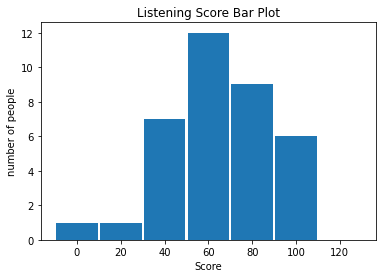

In [58]:
data = Gept_Result(listening, reading)
#data.pair_name()
data.draw_graph('聽力成績')

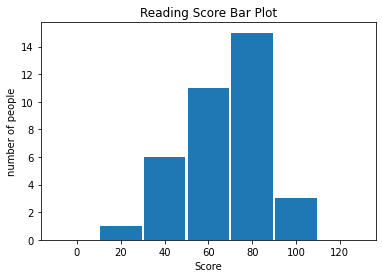

In [59]:
data.draw_graph("閱讀成績")

In [60]:
# pair names in the two csv files
data.pair_name().head()

,姓名,聽力成績,閱讀成績
0,商湯,96 / 120,77 / 120
1,武丁,68 / 120,71 / 120
2,周文王,44 / 120,50 / 120
3,召公,92 / 120,100 / 120
4,魯班,60 / 120,69 / 120


In [61]:
# clean the table
data.clean_table().head()

,姓名,聽力成績,閱讀成績,總成績
0,商湯,96,77,173
1,武丁,68,71,139
2,周文王,44,50,94
3,召公,92,100,192
4,魯班,60,69,129


In [62]:
# show the people who passed/ didn't pass the test
data.show_pass_notPass().head()

,姓名,聽力成績,閱讀成績,總成績,通過
0,商湯,96,77,173,True
1,武丁,68,71,139,False
2,周文王,44,50,94,False
3,召公,92,100,192,True
4,魯班,60,69,129,False


In [63]:
data.group_true_false(True)

,姓名,聽力成績,閱讀成績,總成績,通過
27,法顯,100,103,203,True
3,召公,92,100,192,True
17,王充,96,82,178,True
21,張角,92,85,177,True
0,商湯,96,77,173,True
24,祖逖,72,90,162,True


From the below graph, listening score and reading score is somewhat related ($r^2 = 0.60$). One explanation is that student tries to improve reading and listening ability using the same effort before taking the test.

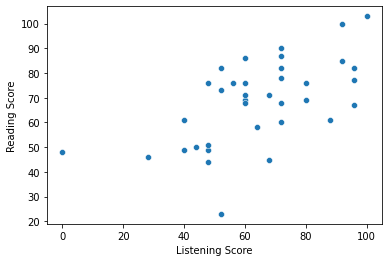

The correlation coefficient will be0.597837786237495


In [64]:
# show the correlation between listening score and reading score
data.correlation()